In [11]:
# Cell 1: Imports Yada Yada
import os
import glob
import numpy as np
import pandas as pd
import h5py
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    precision_recall_curve, average_precision_score
)

print("TensorFlow Version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Num GPUs Available: {len(gpus)}")
    for gpu in gpus:
        print(f"  - {gpu.name}")
else:
    print("No GPU detected. TensorFlow will use the CPU.")

TensorFlow Version: 2.14.0
Num GPUs Available: 1
  - /physical_device:GPU:0


In [ ]:
import os
import glob
import uproot
import h5py
import pandas as pd
import numpy as np
import awkward as ak
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# The list of features to be used for training the model.
selected_variables = [
    "jet1_pt",
    "jet1met_dphi",
    "met_sig", "met_pt"
]

# Path for the new DM signal samples
base_dir_DM_sig = "/home/sgoswami/monobcntuples/local-samples/trf-workdir/SR/flattenedNTuples/sig/dm"
# Path for the existing background samples
base_dir_BKG      = "/home/sgoswami/monobcntuples/"
bkg_procs = ["ttbar", "wlnu", "znunu"]


# --- Helper Functions ---
def importance_shuffle(X, y=None):
    """Shuffles a DataFrame and an optional label array in unison."""
    idx = np.random.permutation(len(X))
    Xs = X.iloc[idx].reset_index(drop=True)
    if y is None: return Xs
    return Xs, y[idx]

def filter_ok(paths):
    """Filters out histogram and cutflow files."""
    return [f for f in paths if "_histogram" not in f and "_cutflow" not in f]

# Function to load data from ROOT files for DM Signal
def load_root_data(file_list, label, tree_names=["b_tagged", "untagged"]):
    """Loads data from a list of ROOT files, checking specified TTrees."""
    dfs = []
    print(f"  Loading {len(file_list)} ROOT file(s)...")
    for f in file_list:
        try:
            with uproot.open(f) as root_file:
                for tree_name in tree_names:
                    if tree_name in root_file:
                        tree = root_file[tree_name]
                        # Check if all selected variables are in the tree
                        missing_vars = [v for v in selected_variables if v not in tree]
                        if missing_vars:
                            print(f"    WARNING: In tree '{tree_name}', missing variables: {missing_vars}. Skipping this tree.")
                            continue

                        df_single = tree.arrays(selected_variables, library="pd")
                        print(f"    -> Loaded {len(df_single)} events from: {os.path.basename(f)}/{tree_name}")
                        dfs.append(df_single)
        except Exception as e:
            print(f"Warning: Could not process ROOT file {f}. Reason: {e}")

    if not dfs: return pd.DataFrame(columns=selected_variables), np.array([])
    combined = pd.concat(dfs, axis=0).reset_index(drop=True)
    return combined, np.full(len(combined), label)

def load_h5_data(file_list, label):
    """Loads data from a list of HDF5 files (for background)."""
    dfs = []
    print(f"  Loading {len(file_list)} H5 file(s)...")
    for f in file_list:
        try:
            with h5py.File(f, "r") as hf:
                cols0 = [n.decode() for n in hf["df/block0_items"][:]]
                vals0 = pd.DataFrame(hf["df/block0_values"][:], columns=cols0)
                cols1 = [n.decode() for n in hf["df/block1_items"][:]]
                vals1 = pd.DataFrame(hf["df/block1_values"][:], columns=cols1)
            df_single = pd.concat([vals0, vals1], axis=1)[selected_variables]
            print(f"    -> Loaded {len(df_single)} events from: {os.path.basename(f)}")
            dfs.append(df_single)
        except Exception as e:
            print(f"Warning: Could not process H5 file {f}. Reason: {e}")
    if not dfs: return pd.DataFrame(columns=selected_variables), np.array([])
    combined = pd.concat(dfs, axis=0).reset_index(drop=True)
    return combined, np.full(len(combined), label)


# Proportional Background Sampling Setup (Unchanged)
target_yields = {
    'ttbar': 55420.2,
    'wlnu': 516779.0,
    'znunu': 702063.8,
}
_total_target_bkg = sum(target_yields.values())
bkg_proportions = {p: xs/_total_target_bkg for p, xs in target_yields.items()}


# Dataset Preparation Function for DM
def prepare_DM():
    """Prepares the Dark Matter (DM) dataset with proportional background sampling."""
    print("--- Preparing Dark Matter (DM) Dataset ---")

    print("\nInitial Target Background Proportions:")
    for proc, prop in bkg_proportions.items():
        print(f"  - {proc}: {prop:.2%}")

    # Find DM signal files
    print("\nLoading DM signal files:")
    sig_files = glob.glob(os.path.join(base_dir_DM_sig, "flat_tuple_yy_*.root"))

    # Load all signal events to determine the total number of events (S)
    sig_df, sig_lbl = load_root_data(sig_files, 1) # Use the new ROOT loader
    S = len(sig_df)
    if S == 0:
        print("FATAL: No signal events were loaded. Please check paths and file contents. Exiting.")
        exit()
    print(f"Loaded {S} total signal events.")

    # Calculate how many events to sample for each background process to match S
    bkg_counts = {p: int(round(S * bkg_proportions[p])) for p in bkg_procs}
    diff = S - sum(bkg_counts.values()); bkg_counts[bkg_procs[-1]] += diff

    bkg_parts, bkg_files_map = [], {}
    print("\nSampling background events proportionally...")
    for proc in bkg_procs:
        n_req = bkg_counts[proc]
        if n_req == 0: continue

        print(f"Processing background: {proc}")
        # Construct file paths for background H5 files
        if proc == 'wlnu':
            dirs = ['wenu_mc20e','wmunu_mc20e','wtaunu_mc20e']
            files = sum((glob.glob(os.path.join(base_dir_BKG, d, "*.h5")) for d in dirs), [])
        else:
            files = glob.glob(os.path.join(base_dir_BKG, f"{proc}_mc20e", "*.h5"))

        files = filter_ok(files)
        bkg_files_map[proc] = files
        if not files:
            print(f"  No files found for {proc}. Skipping.")
            continue

        # Load all available events for the process using the H5 loader
        df_all, _ = load_h5_data(files, 0)
        if len(df_all) == 0:
            print(f"  No events loaded for {proc}. Skipping sampling.")
            continue

        # Sample the required number of events
        replace = n_req > len(df_all)
        print(f"  Requesting {n_req} events (replacement={replace})...")
        df_samp = df_all.sample(n=n_req, replace=replace, random_state=42).reset_index(drop=True)
        bkg_parts.append(df_samp)

    bkg_df = pd.concat(bkg_parts, axis=0).reset_index(drop=True)

    total_loaded_bkg = len(bkg_df)
    if total_loaded_bkg > 0:
        print("\nFinal Loaded Background Proportions (after sampling):")
        for proc, count in bkg_counts.items():
            final_prop = count / total_loaded_bkg
            print(f"  - {proc}: {final_prop:.2%}")

    bkg_df = importance_shuffle(bkg_df)

    # Combine signal and background into final dataset
    X_dm = pd.concat([sig_df, bkg_df], axis=0).reset_index(drop=True)
    y_dm = np.concatenate([sig_lbl, np.zeros(len(bkg_df), dtype=int)])
    return importance_shuffle(X_dm, y_dm), sig_files, bkg_files_map


# --- Final Data Loading and Splitting ---
(X_df, y_array), dm_sig_files, dm_bkg_files = prepare_DM() # Call the new function

# --- Loading Summary ---
print("\n--- Files Loaded Summary ---")
print("\nDM Signal Files:")
for f in sorted(dm_sig_files): print(f"  {f}")

print("\nBackground Files by Process:")
for proc, files in dm_bkg_files.items():
    if not files: continue
    print(f"  Process: {proc}")
    for f in sorted(files): print(f"    {f}")
print("----------------------------\n")

print(f"Final dataset shape: {X_df.shape}")
print(f"Final class distribution: {np.bincount(y_array)}")

# Split the data into training and validation sets
X_train_df, X_val_df, y_train, y_val = train_test_split(
    X_df, y_array, test_size=0.2, random_state=42, stratify=y_array
)

print(f"\nTrain set shape: {X_train_df.shape}")
print(f"Validation set shape:  {X_val_df.shape}")

--- Preparing Dark Matter (DM) Dataset ---

Initial Target Background Proportions:
  - ttbar: 4.35%
  - wlnu: 40.56%
  - znunu: 55.10%

Loading DM signal files:
  Loading 3 ROOT file(s)...
    -> Loaded 2916 events from: flat_tuple_yy_1p0_qcd.root/b_tagged
    -> Loaded 9891 events from: flat_tuple_yy_1p0_qcd.root/untagged
    -> Loaded 5471 events from: flat_tuple_yy_1p5_qcd.root/b_tagged
    -> Loaded 21414 events from: flat_tuple_yy_1p5_qcd.root/untagged
    -> Loaded 8921 events from: flat_tuple_yy_2p5_qcd.root/b_tagged
    -> Loaded 43223 events from: flat_tuple_yy_2p5_qcd.root/untagged
Loaded 91836 total signal events.

Sampling background events proportionally...
Processing background: ttbar
  Loading 1 H5 file(s)...
    -> Loaded 591385 events from: basicSel_ttbar_mc20e.h5
  Requesting 3994 events (replacement=False)...
Processing background: wlnu
  Loading 3 H5 file(s)...
    -> Loaded 1757384 events from: basicSel_wenu_mc20e.h5
    -> Loaded 2450997 events from: basicSel_wmun

Data integrity check:
                 count        mean         std         min         25%  \
jet1_pt       146937.0  809.528422  620.307233  150.007507  258.682465   
jet1met_dphi  146937.0    2.451177    0.790139    0.000049    2.247604   
met_sig       146937.0   10.420077    5.351752    0.769567    5.300546   
met_pt        146937.0  339.903919  182.675127  200.000153  235.679901   

                     50%          75%          max  
jet1_pt       608.765198  1277.575806  4014.741455  
jet1met_dphi    2.766294     2.992915     3.141592  
met_sig        10.954413    14.274815   121.138351  
met_pt        286.167114   380.043060  8323.280273  

Checking for NaN values:
jet1_pt         0
jet1met_dphi    0
met_sig         0
met_pt          0
dtype: int64


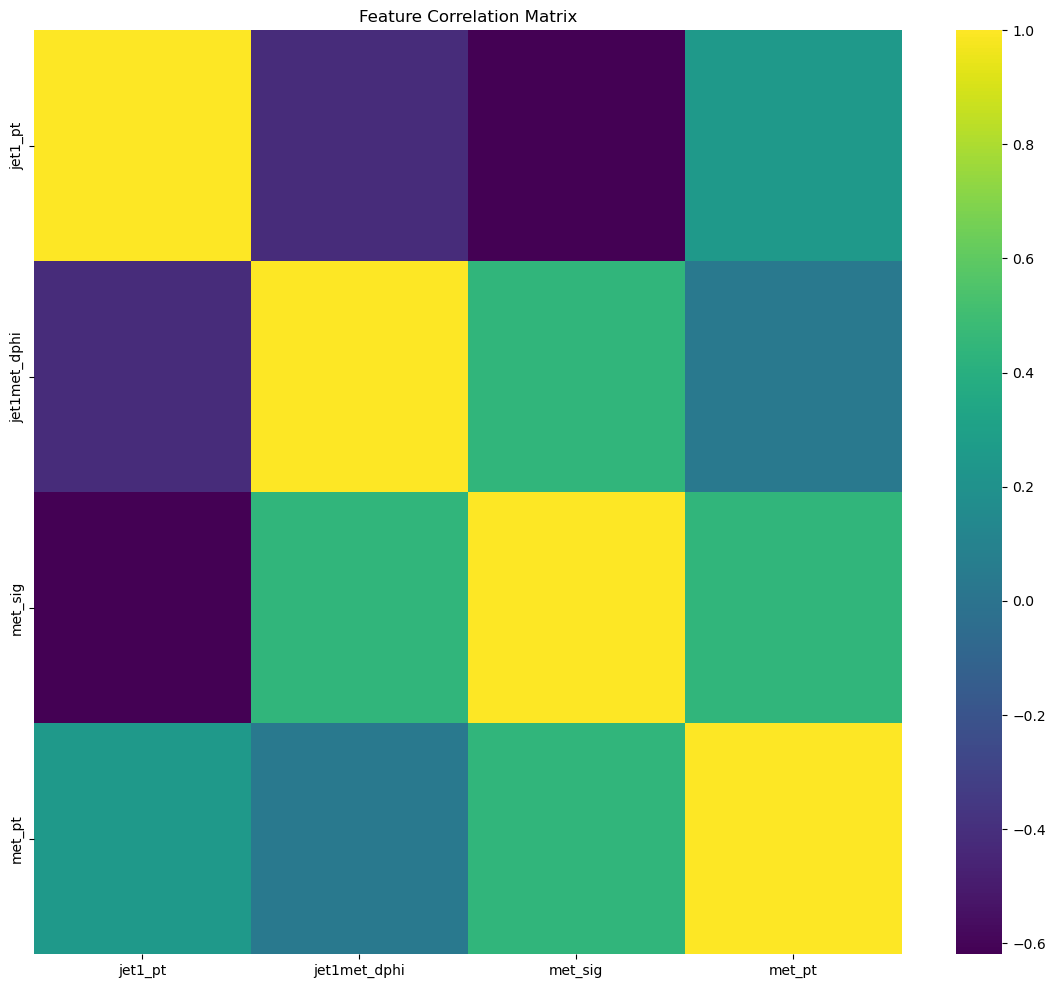

In [13]:
# Cell 3: Data Analysis & Visualization
import seaborn as sns

# Data integrity check
print("Data integrity check:")
print(X_train_df.describe().transpose())
print("\nChecking for NaN values:")
print(X_train_df.isna().sum())

# Feature Correlation Matrix
plt.figure(figsize=(14, 12))
correlation_matrix = X_train_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='viridis')
plt.title('Feature Correlation Matrix')
plt.show()

In [14]:
# Cell 4: Define Model, Optimizer, and Callbacks

def build_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, kernel_initializer='he_normal', activation='gelu'),
        BatchNormalization(),
        Dense(64, kernel_initializer='he_normal', activation='gelu'),
        BatchNormalization(),
        Dense(32, kernel_initializer='he_normal', activation='gelu'),
        BatchNormalization(),
        Dense(1, kernel_initializer='he_normal', activation='sigmoid'),
    ])
    return model

# saving to .keras (old loader causes issues)

lr          = 5e-5
epochs      = 150
batch_size  = 512

metric_list = [
    AUC(name='auc'),
    'accuracy',
    Precision(name='precision'),
    Recall(name='recall')
]

callbacks = [
    EarlyStopping(
        monitor='val_auc',
        patience=20,
        mode='max',
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.2,
        patience=7,
        mode='max',
        verbose=1,
        min_lr=1e-7
    ),
]

model = build_model(input_dim=X_train_df.shape[1])

model.compile(
    optimizer=Adam(learning_rate=lr),
    loss='binary_crossentropy',
    metrics=metric_list
)

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               640       
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_4 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_5 (Bat  (None, 32)               

In [15]:
# Cell 5: Train Model

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df.values)
X_val = scaler.transform(X_val_df.values)

print(f"Starting training with LR={lr}, BS={batch_size}, Epochs={epochs}")
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)
model.save("best_model_dm.keras", save_format="keras")

Starting training with LR=5e-05, BS=512, Epochs=150
Epoch 1/150


287/287 [==============================] - 3s 5ms/step - loss: 0.4027 - auc: 0.9156 - accuracy: 0.8343 - precision: 0.8449 - recall: 0.8190 - val_loss: 0.1500 - val_auc: 0.9981 - val_accuracy: 0.9901 - val_precision: 0.9859 - val_recall: 0.9943 - lr: 5.0000e-05
Epoch 2/150
287/287 [==============================] - 1s 4ms/step - loss: 0.0872 - auc: 0.9987 - accuracy: 0.9918 - precision: 0.9874 - recall: 0.9963 - val_loss: 0.0617 - val_auc: 0.9989 - val_accuracy: 0.9930 - val_precision: 0.9882 - val_recall: 0.9979 - lr: 5.0000e-05
Epoch 3/150
287/287 [==============================] - 1s 4ms/step - loss: 0.0527 - auc: 0.9989 - accuracy: 0.9932 - precision: 0.9892 - recall: 0.9972 - val_loss: 0.0435 - val_auc: 0.9990 - val_accuracy: 0.9938 - val_precision: 0.9902 - val_recall: 0.9976 - lr: 5.0000e-05
Epoch 4/150
287/287 [==============================] - 1s 4ms/step - loss: 0.0389 - auc: 0.9990 - accuracy: 0.9938 - precision: 0.9908 - recall: 0.9969 - val_loss: 0.0342 - val_auc: 0.9990 -

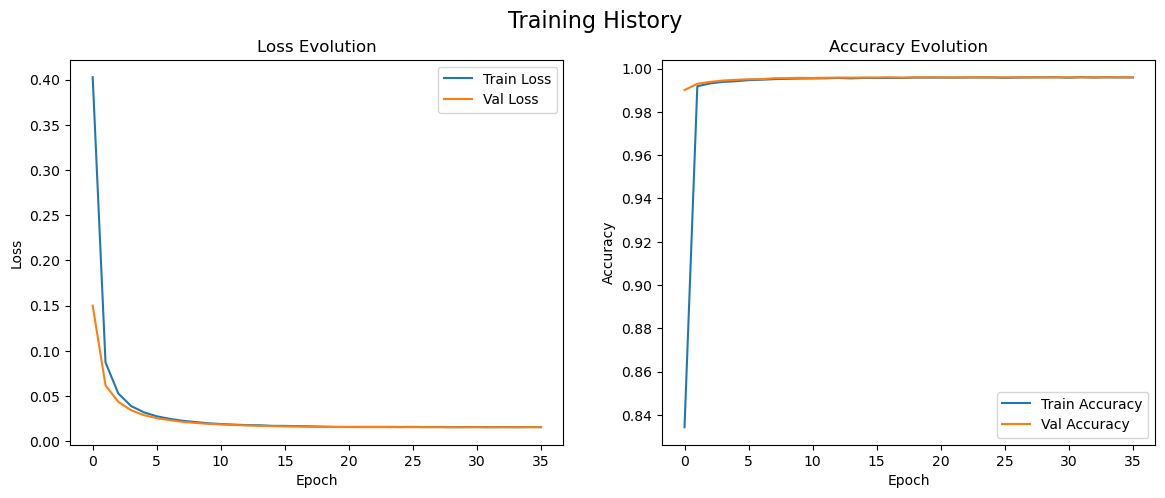

1148/1148 [==============================] - 1s 877us/step


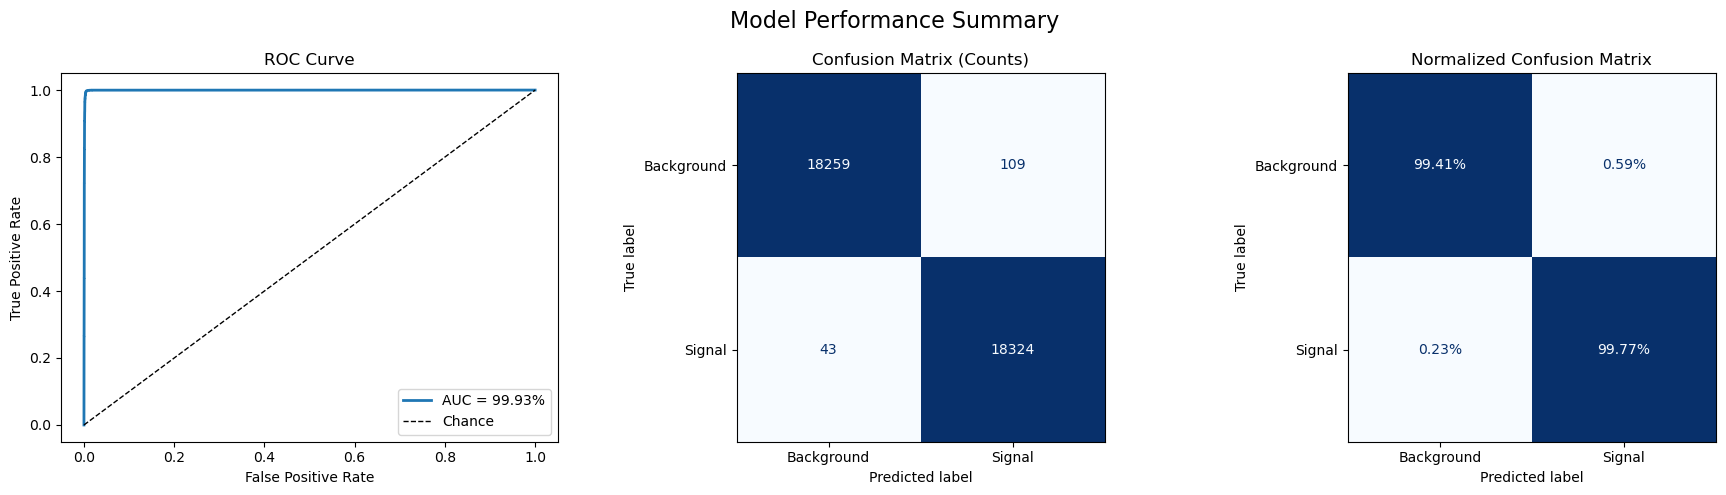

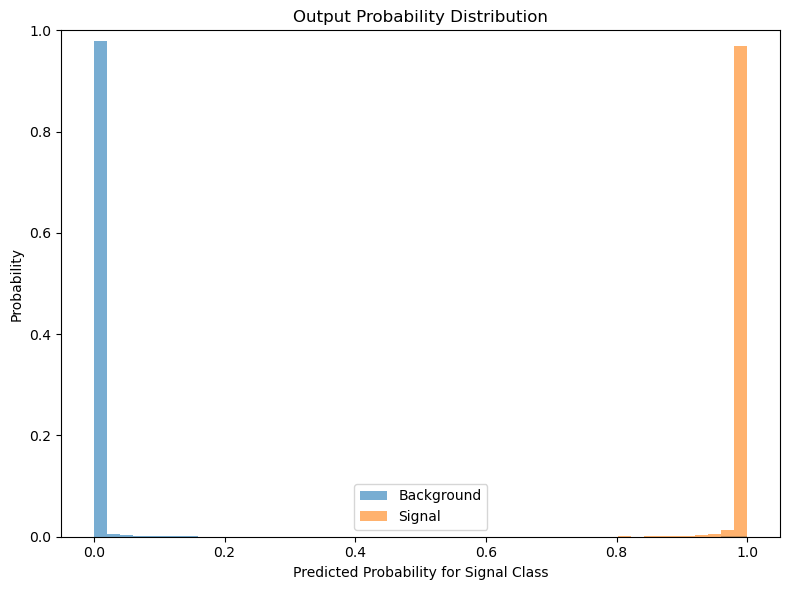

In [16]:
# Cell 6: Evaluate Model and Plot Results
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
# Plot Loss and Accuracy vs. Epoch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Training History', fontsize=16)

ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Val Loss')
ax1.set_title('Loss Evolution')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Val Accuracy')
ax2.set_title('Accuracy Evolution')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

y_pred_probs = model.predict(X_val).squeeze()
y_pred_class = (y_pred_probs > 0.5).astype(int)

y_pred_class = (y_pred_probs > 0.5).astype(int)
fpr, tpr, _ = roc_curve(y_val, y_pred_probs)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(y_val, y_pred_class)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Model Performance Summary', fontsize=16)

# Plot 1: ROC Curve
ax1.plot(fpr, tpr, label=f'AUC = {roc_auc*100:.2f}%', lw=2)
ax1.plot([0, 1], [0, 1], 'k--', lw=1, label='Chance')
ax1.set_title('ROC Curve')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc='lower right')

# Plot 2: Confusion Matrix (Raw Counts)
disp1 = ConfusionMatrixDisplay(cm, display_labels=['Background', 'Signal'])
disp1.plot(ax=ax2, cmap='Blues', colorbar=False, values_format='d')
ax2.set_title('Confusion Matrix (Counts)')

# Plot 2A: Normalized Confusion Matrix (Percentages)
disp2 = ConfusionMatrixDisplay(cm_norm, display_labels=['Background', 'Signal'])
disp2.plot(ax=ax3, cmap='Blues', colorbar=False, values_format='.2%')
ax3.set_title('Normalized Confusion Matrix')

plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# split your predictions
probs_bg = y_pred_probs[y_val == 0]
probs_sig = y_pred_probs[y_val == 1]

# make weights that sum to 1
w_bg  = np.ones_like(probs_bg)  / probs_bg.size
w_sig = np.ones_like(probs_sig) / probs_sig.size

plt.figure(figsize=(8, 6))
# now each histogram is properly normalized so sum(bin_heights) == 1
plt.hist(probs_bg,  bins=50, alpha=0.6, label='Background', weights=w_bg)
plt.hist(probs_sig, bins=50, alpha=0.6, label='Signal',     weights=w_sig)

plt.xlabel('Predicted Probability for Signal Class')
plt.ylabel('Probability')         # now represents P(bin)
plt.title('Output Probability Distribution')
plt.legend()

# optionally force y‐axis to [0,1]
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

--- Calculating and Plotting Feature Importance ---
Baseline Validation AUC: 0.9993


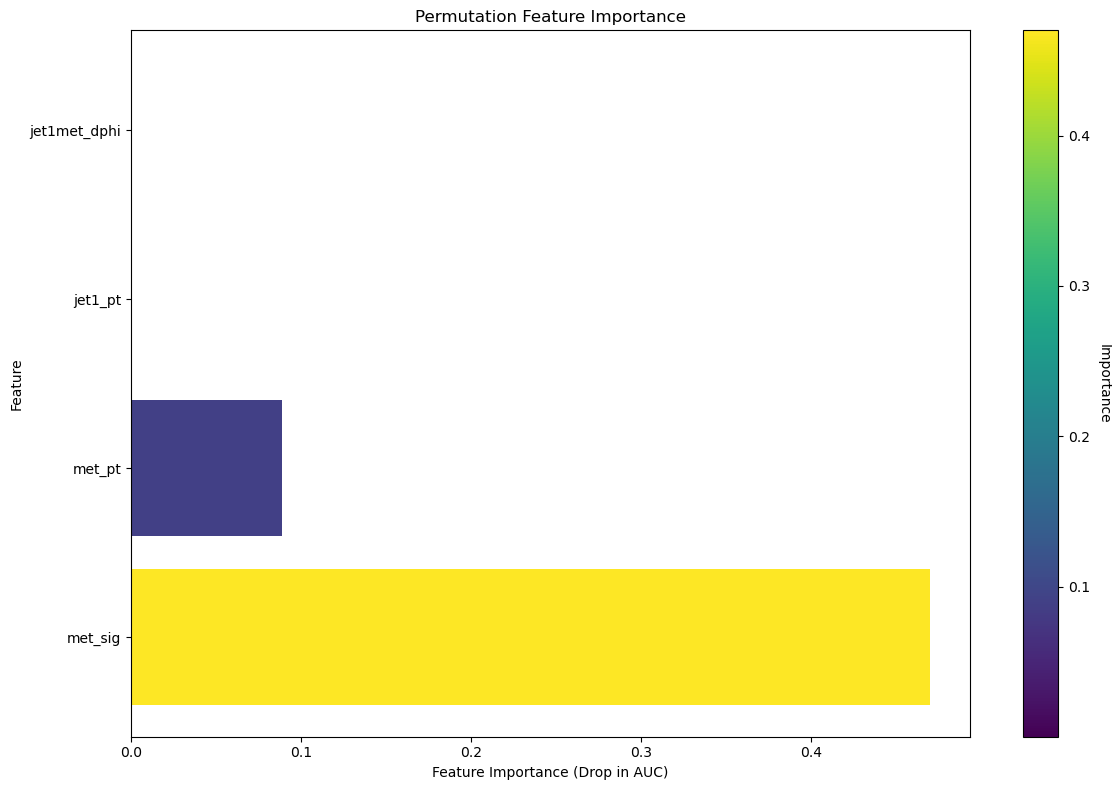

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import tensorflow as tf
from sklearn.metrics import roc_auc_score

print("--- Calculating and Plotting Feature Importance ---")

model = tf.keras.models.load_model('best_model_dm.keras')

y_pred_baseline = model.predict(X_val, batch_size=batch_size, verbose=0).squeeze()
baseline_auc = roc_auc_score(y_val, y_pred_baseline)
print(f"Baseline Validation AUC: {baseline_auc:.4f}")

importances = []

for i in range(X_val.shape[1]):
    X_val_permuted = X_val.copy()
    np.random.shuffle(X_val_permuted[:, i])

    y_pred_permuted = model.predict(X_val_permuted, batch_size=batch_size, verbose=0).squeeze()
    permuted_auc = roc_auc_score(y_val, y_pred_permuted)

    feature_importance = baseline_auc - permuted_auc
    importances.append(feature_importance)


importance_df = pd.DataFrame({
    'feature': selected_variables,
    'importance': importances
}).sort_values(by='importance', ascending=True)


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

cmap = plt.get_cmap('viridis')
norm = plt.Normalize(
    vmin=importance_df['importance'].min(),
    vmax=importance_df['importance'].max()
)


ax.barh(
    importance_df['feature'],
    importance_df['importance'],
    color=cmap(norm(importance_df['importance']))
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Importance', rotation=270, labelpad=15)

ax.set_xlabel("Feature Importance (Drop in AUC)")
ax.set_ylabel("Feature")
ax.set_title("Permutation Feature Importance")
ax.invert_yaxis()

fig.tight_layout()
plt.show()

In [18]:
import uproot
import pandas as pd
import numpy as np
import tensorflow as tf
import os

print("--- Starting NTuple processing for Dark Matter (DM) ---")
print("--- NOTE: Using a default event weight of 1.0 ---")

# --- Configuration ---

# 1. Path to your trained Keras model.
# This model's input layer MUST match the number of features in the FEATURES list below.
MODEL_PATH = "/home/sgoswami/monobcntuples/ML/best_model_dm.keras"

# 2. Base path for input ntuples
NTUPLE_BASE_PATH = "/home/sgoswami/monobcntuples/local-samples/trf-workdir/SR/flattenedNTuples"

# 3. --- MODIFIED: Output ROOT file for DM analysis ---
OUTPUT_FILE = "discriminant_ntuples_dm.root"

# 4. List of features the model was trained on.
# This MUST match your model's inputs and the branch names in your files.
FEATURES = [
    "jet1_pt",
    "jet1met_dphi",
    "met_sig", "met_pt"
]

# 5. Define the source tree categories to process
CATEGORIES = ["b_tagged", "untagged"]

# 6. --- MODIFIED: Define the input files for the DM signal samples ---
SIGNAL_FILES = {
    "DM_1p0": f"{NTUPLE_BASE_PATH}/sig/dm/flat_tuple_yy_1p0_qcd.root",
    "DM_1p5": f"{NTUPLE_BASE_PATH}/sig/dm/flat_tuple_yy_1p5_qcd.root",
    "DM_2p5": f"{NTUPLE_BASE_PATH}/sig/dm/flat_tuple_yy_2p5_qcd.root",
}

# 7. --- UNCHANGED: Background files remain the same ---
BACKGROUND_FILES = {
    "znunu": f"{NTUPLE_BASE_PATH}/bkg/flat_tuple_znunu_600K.root",
    "ttbar": f"{NTUPLE_BASE_PATH}/bkg/flat_tuple_ttbar.root",
    "wjets": [
        f"{NTUPLE_BASE_PATH}/bkg/flat_tuple_wlnu.root",
    ]
}

# --- Data Processing Function ---

def load_category_and_predict(file_paths, category_name, model, features_list):
    """Loads data for a specific category from files and runs prediction."""
    if not isinstance(file_paths, list):
        file_paths = [file_paths]

    all_events_df = []
    for path in file_paths:
        if not os.path.exists(path):
            print(f"    WARNING: File not found, skipping: {path}")
            continue
        try:
            with uproot.open(path) as f:
                if category_name in f:
                    tree = f[category_name]
                    # Check if all features for the model are available
                    missing_vars = [v for v in features_list if v not in tree]
                    if missing_vars:
                        print(f"    WARNING: In '{path}/{category_name}', missing features: {missing_vars}. Skipping tree.")
                        continue
                    df = tree.arrays(features_list, library="pd")
                    if len(df) > 0:
                        all_events_df.append(df)
        except Exception as e:
            print(f"    ERROR processing {path}: {e}")

    if not all_events_df:
        return None

    full_df = pd.concat(all_events_df, ignore_index=True)
    # Ensure features are in the correct order for the model
    features_df = full_df[features_list]

    predictions = model.predict(features_df.values, batch_size=1024)
    # Handle both single-output (regression) and double-output (classification) models
    discriminant = predictions[:, 1] if predictions.ndim == 2 and predictions.shape[1] == 2 else predictions.flatten()

    return discriminant

# --- Script Execution ---

print(f"Loading Keras model from {MODEL_PATH}...")
try:
    model = tf.keras.models.load_model(MODEL_PATH)
    model.summary()
except Exception as e:
    print(f"FATAL: Could not load Keras model. Error: {e}")
    exit()

print(f"\nAttempting to create output file: {OUTPUT_FILE}")
with uproot.recreate(OUTPUT_FILE) as f:
    # Combine all signal and background samples into one dictionary for processing
    all_samples = {**SIGNAL_FILES, **BACKGROUND_FILES}
    for sample_name, path in all_samples.items():
        print(f"Processing sample: '{sample_name}'...")
        for category in CATEGORIES:
            discriminant = load_category_and_predict(path, category, model, FEATURES)

            if discriminant is not None:
                # --- MODIFIED: Create TTree name with a "_dm" suffix ---
                tree_name = f"{sample_name}_{category}_dm"
                f[tree_name] = {
                    "discriminant_dm": discriminant,
                    "eventWeight_dm": np.ones(len(discriminant), dtype=np.float32)
                }
                print(f"  -> Wrote {len(discriminant)} events to TTree '{tree_name}'")

print("\n--- Script Finished ---")

--- Starting NTuple processing for Dark Matter (DM) ---
--- NOTE: Using a default event weight of 1.0 ---
Loading Keras model from /home/sgoswami/monobcntuples/ML/best_model_dm.keras...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               640       
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_4 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 



Attempting to create output file: discriminant_ntuples_dm.root
Processing sample: 'DM_1p0'...
3/3 [==============================] - 0s 2ms/step
  -> Wrote 2916 events to TTree 'DM_1p0_b_tagged_dm'
10/10 [==============================] - 0s 993us/step
  -> Wrote 9891 events to TTree 'DM_1p0_untagged_dm'
Processing sample: 'DM_1p5'...
6/6 [==============================] - 0s 1ms/step
  -> Wrote 5471 events to TTree 'DM_1p5_b_tagged_dm'
21/21 [==============================] - 0s 1ms/step
  -> Wrote 21414 events to TTree 'DM_1p5_untagged_dm'
Processing sample: 'DM_2p5'...
9/9 [==============================] - 0s 1ms/step
  -> Wrote 8921 events to TTree 'DM_2p5_b_tagged_dm'
43/43 [==============================] - 0s 929us/step
  -> Wrote 43223 events to TTree 'DM_2p5_untagged_dm'
Processing sample: 'znunu'...
1/1 [==============================] - 0s 17ms/step
  -> Wrote 707 events to TTree 'znunu_b_tagged_dm'
7/7 [==============================] - 0s 1ms/step
  -> Wrote 6194 events 